## LSTM 

In [1]:
## for data
import json
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D
from keras.layers.recurrent import LSTM
from keras.layers import Activation, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for processing
import re
import nltk
from nltk.tokenize import word_tokenize
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, feature_selection, metrics

## for explainer
from lime import lime_text

## for word embedding
import gensim
import gensim.downloader as gensim_api

## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

## for bert language model
import transformers

/home/dee/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
df = pd.read_csv("yoruba_newsclass/train_clean.tsv", sep='\t')
df1 = pd.read_csv("yoruba_newsclass/test.tsv", sep='\t')
df2 = pd.read_csv("yoruba_newsclass/dev.tsv", sep='\t')
frames = [df, df1, df2]
df = pd.concat(frames)

In [3]:
df['label'].unique()

array(['africa', 'politics', 'nigeria', 'entertainment', 'world',
       'health', 'sport'], dtype=object)

In [4]:
df['label'].unique()

array(['africa', 'politics', 'nigeria', 'entertainment', 'world',
       'health', 'sport'], dtype=object)

In [5]:
df = df.replace("nigeria", "politics")
df = df.replace("africa", "world")

In [6]:
df['label'].unique()

array(['world', 'politics', 'entertainment', 'health', 'sport'],
      dtype=object)

In [7]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    no_integers = [x for x in lst_text if not (x.isdigit() or x[0] == '-' and x[1:].isdigit())]
    text = " ".join(no_integers)
    return text

    

In [8]:
#lst_stopwohttp://localhost:8888/notebooks/TEXT%20CLASSIFICATION%20PROJECT/Text%20Summarization%20with%20LSTM-Yoruba.ipynb#rds = nltk.corpus.stopwords.words("german")
#lst_stopwords

#nltk.download('stopwords')
lst_stopwords = pd.read_csv('yo.txt', header=None)
lst_stopwords = np.array(lst_stopwords[0])
#lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords

array(['ó', 'ní', 'ṣe', 'rẹ̀', 'tí', 'àwọn', 'sí', 'ni', 'náà', 'láti',
       'kan', 'ti', 'ń', 'lọ', 'o', 'bí', 'padà', 'sì', 'wá', 'lè', 'wà',
       'kí', 'púpọ̀', 'mi', 'wọ́n', 'pẹ̀lú', 'a', 'ṣùgbọ́n', 'fún', 'jẹ́',
       'fẹ́', 'kò', 'jù', 'pé', 'é', 'gbogbo', 'inú', 'bẹ̀rẹ̀', 'jẹ',
       'ọjọ́', 'nítorí', 'nǹkan', 'sínú', 'ṣ', 'yìí', 'ṣé', 'àti', 'í',
       'máa', 'nígbà', 'mo', 'an', 'mọ̀', 'bá', 'kì', 'ńlá', 'ọ̀pọ̀lọpọ̀',
       'ẹmọ́', 'wọn', 'òun'], dtype=object)

In [24]:
#nltk.download('wordnet')
df["text_clean"] = df["news_title"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
df.head()
df.to_csv('data_yoruba_cleaned.csv')

In [10]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text_clean'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(df['text_clean'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)


Found 5182 unique tokens.
Shape of data tensor: (1908, 250)


In [11]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
Y = lb.fit_transform(df['label'])

In [12]:
lb.classes_

array(['entertainment', 'health', 'politics', 'sport', 'world'],
      dtype=object)

In [13]:
#Y = pd.get_dummies(dtf['category']).values
#print('Shape of label tensor:', Y.shape)

X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

#The first layer is the embedded layer that uses 100 length vectors to represent each word.
#SpatialDropout1D performs variational dropout in NLP model_yorubas.
#The next layer is the LSTM layer with 100 memory units.
#The output layer must create 13 output values, one for each class.
#Activation function is softmax for multi-class classification.
#Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function.

model_yoruba = Sequential()
model_yoruba.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model_yoruba.add(SpatialDropout1D(0.2))
model_yoruba.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_yoruba.add(Dense(13, activation='softmax'))
model_yoruba.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_yoruba.summary())

epochs = 50
batch_size = 20

history = model_yoruba.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

(1717, 250) (1717,)
(191, 250) (191,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 250, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 13)                1313      
Total params: 5,081,713
Trainable params: 5,081,713
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
78/78 [==============================] - 36s 416ms/step - loss: 1.3989 - accuracy: 0.5942 - val_loss: 1.0926 - val_accuracy: 0.5756
Epoch 2/50
78/78 [==============================] - 28s 35

6/6 [==============================] - 0s 45ms/step - loss: 1.0470 - accuracy: 0.6911
Test set
  Loss: 1.047
  Accuracy: 0.691


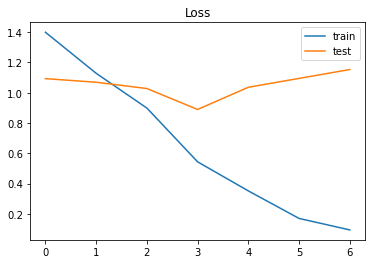

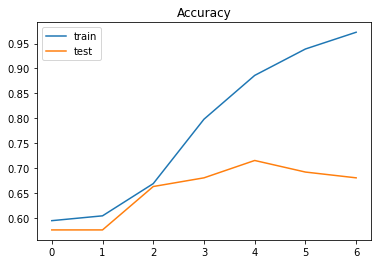

In [14]:
accr = model_yoruba.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [15]:
df['text_clean'].iloc[100]

'countdown orílẹèdè tó ṣáájú nàìjíríà wọ ọdún'

In [16]:
new_complaint = df['text_clean'].iloc[100]
seq = tokenizer.texts_to_sequences([new_complaint])
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model_yoruba.predict(padded)
labels = ['entertainment', 'health', 'politics', 'sport', 'world']
print(pred, labels[np.argmax(pred)])


[[4.2513511e-03 5.5270595e-03 9.8397958e-01 3.6569333e-04 5.5053830e-03
  4.4672135e-05 2.0306805e-05 4.2925061e-05 3.1316238e-05 2.9854278e-05
  3.0102405e-05 1.2165262e-04 5.0108822e-05]] politics


In [17]:
model_yoruba.save("model/LSTM_yoruba.h5")

In [18]:
#Load KERAS model
from keras.models import load_model
# load model
model_yoruba = load_model('model/LSTM_yoruba.h5')